# DeposBA - an explanatory analysis on Buenos Aires real estate data.

This project is a statistical analysis on Buenos Aires, Argentina real estate data, that I scraped from one local website. 

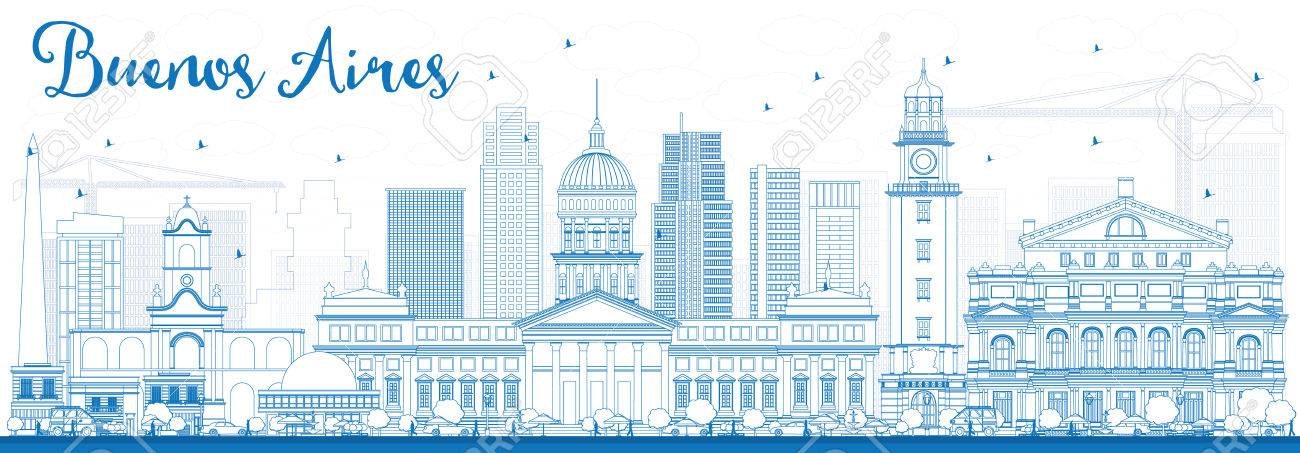

### For index to work please, click [here](https://nbviewer.jupyter.org/github/staskarasev/DeposBA/blob/master/DeposBA.ipynb)


# Index (click to redirect to section)

## [Data Pre-processing](#preprocessing)
- [cleaning the data](#clean-the-data)
 - [information and name](#information-and-name)
 - [price](#price)
 - [covered square](#covered-square)
 - [rooms](#rooms)
 - [age](#age)
 - [district](#district)
 - [bathrooms](#bathrooms)
 - [parking](#parking)
 - [bedrooms](#bedrooms)
 - [expenses](#expenses)
 - [toilet](#toilet)
 - [total_square](#total_square)
 - [price_per_meter](#price_per_meter)
 
## [Summary Statistics](#summary)

## [Bootstrap Hypothesis Testing](#bootstrap)
- [Palermo vs Recoleta. Which district is more expensive?](#palermo-vs-recoleta)
- [Do habitants of Palermo district pay more expenses than habitants of Caballito?](#palermo-vs-caballito)
 
## [Geographic data](#geo-data)
- [average price per m^2](#geo-price)
- [average covered square](#geo-square)
- [average age](#geo-age)

## [Linear Model](#linear-model)


# Gathering data:


Please see gather_data.ipynb for methods. This can be found it [this github repository](https://github.com/staskarasev/DeposBa).

<a id="preprocessing"></a>

## Data Pre-processing

Here we read the data and get a first insight into it.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd
import re 

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import folium
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

import warnings 
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)

plt.style.use('seaborn')

In [2]:
data = pd.read_csv('depos.csv')
data.head(2)

,Unnamed: 0,rooms,age,district,bathrooms,information,parking_lots,bedrooms,expenses,name,price,covered_square,total_square,toilets
0,0,2,Frente,Belgrano,0,"\n\t\t\n\t\t\n\t\t,Cantidad dormitorios: ,2,\n...",2,1,$ 7.000,Departamento · 102m² · 3 Ambientes,298000.0,3,102,3
1,1,4,Frente,Caballito,4,"\n\t\t\n\t\t\n\t\t,Cantidad pisos en edificio:...",1,3,$ 9.900,Departamento · 141m² · 4 Ambientes · 1 Cochera,490000.0,141m²,154,9


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16634 entries, 0 to 16633
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      16634 non-null  int64  
 1   rooms           16630 non-null  object 
 2   age             13590 non-null  object 
 3   district        16634 non-null  object 
 4   bathrooms       16622 non-null  object 
 5   information     16355 non-null  object 
 6   parking_lots    16553 non-null  object 
 7   bedrooms        16067 non-null  object 
 8   expenses        10024 non-null  object 
 9   name            16634 non-null  object 
 10  price           16634 non-null  float64
 11  covered_square  16634 non-null  object 
 12  total_square    16634 non-null  int64  
 13  toilets         14787 non-null  object 
dtypes: float64(1), int64(2), object(11)
memory usage: 1.8+ MB


In [4]:
data.drop('Unnamed: 0', axis=1, inplace=True) # drop Unnamed column
print('Missing data: ')
print(data.isna().sum())# NaN values

Missing data: 
rooms                4
age               3044
district             0
bathrooms           12
information        279
parking_lots        81
bedrooms           567
expenses          6610
name                 0
price                0
covered_square       0
total_square         0
toilets           1847
dtype: int64


<a id="clean-the-data"></a>
## Cleaning the data

Here we need to do:

* Trasform, extract some data from <code>information</code> and <code>name</code> columns.

* Create new variables (floors_per_building, swimming_pool, gym, sum, security) that can be useful for price inference.

* Deal with <code>NaN</code> values

* Drop outliers

* Convert string data into numeric data

<a id="information-and-name"></a>

### 'information' and 'name' 

In [5]:
data.information[0] # example of data in the information column

'\n\t\t\n\t\t\n\t\t,Cantidad dormitorios: ,2,\n\t\t\n\t\t\n\t\t\n\t\t,Superficie del terreno (m²): ,0,\n\t\t\n\t\t\n\t\t\n\t\t,Pileta ,\n\t\t\n\t\t\n\t,\n\t\t\n\t\t\n\t\t,Gas natural ,\n\t\t\n\t\t\n\t\t\n\t\t,Luz ,\n\t\t\n\t\t\n\t\t\n\t\t,Agua corriente ,\n\t\t\n\t\t\n\t\t\n\t\t,Pavimento ,\n\t\t\n\t\t\n\t,\n\t\t\n\t\t\n\t\t,Cocina ,\n\t\t\n\t\t\n\t\t\n\t\t,Lavadero ,\n\t\t\n\t\t\n\t\t\n\t\t,Balcón ,\n\t\t\n\t\t\n\t\t\n\t\t,Living comedor ,\n\t\t\n\t\t\n\t\t\n\t\t,Hall ,\n\t\t\n\t\t\n\t,\n\t\t\n\t\t\n\t\t,Calefacción ,\n\t\t\n\t\t\n\t\t\n\t\t,SUM ,\n\t\t\n\t\t\n\t'

In [6]:
def info_extracter(line):
    """Auxiliary function designed for extracting string values from information column
    
    Parameters:
    ===========
    line - A line with un pre-processed data.
    
    Output:
    ==========
    List of processed string values.
    """
    
    # Removes tabs, spaces and extra commas
    line = line.replace('\t','').replace('\n','').replace(',',' ').strip()
    
    # Extracts values we are interested in 
    regex =  r"Cantidad dormitorios:  \d|Cantidad pisos en edificio:  \d|Departamentos por piso:  \d|Pileta|Gimnasio|SUM|Vigilancia"
    line = re.findall(regex, line)
    
    return str(line)

In [7]:
data.information = data.information.astype('str')
data.name = data.name.astype('str')

data.information = data.information.map(lambda x: info_extracter(x))
data.sample(2)

,rooms,age,district,bathrooms,information,parking_lots,bedrooms,expenses,name,price,covered_square,total_square,toilets
7973,1,60,Tribunales,1,['Cantidad dormitorios: 1'],0,0,$ 1.500,Departamento · 27m² · 1 Ambiente,69000.0,27m²,27,0
13764,2,NaN,Recoleta,1,"['Gimnasio', 'Pileta']",1,En construcción,NaN,Departamento · 43m² · 2 Ambientes,215000.0,43m²,56,NaN


Column <code>name</code> has some useful information like:

* covered square of department

* rooms quantity

* parking lots

I will create new columns with this values for double check.

In [8]:
# extracting values from name column
data['parking_lots_2'] = data.name.str.extract(r'(\d+)\s*Cochera?\b')
data['bedrooms_2'] = data.information.str.extract(r'dormitorios\W\s+(\d+)')
data['rooms_2'] = data.name.str.extract(r'(\d+)\s*Ambientes?\b')
data['covered_square_2'] = data.name.str.extract(r'(\d+)m²')

# extracting values from information column
data['floors_per_building'] = data.information.str.extract(r'\w{2}\s\w{8}\W\s+(\d+)')
data['swimming_pool'] = data.information.str.extract(r'(Pileta)')
data['gym'] = data.information.str.extract(r'(Gimnasio)') 
data['sum'] = data.information.str.extract(r'(SUM)')
data['security'] = data.information.str.extract(r'(Vigilancia)')

# converting values to Dummies
data['swimming_pool'] = data['swimming_pool'].map({'Pileta':'1'})
data['gym'] = data['gym'].map({'Gimnasio':'1'})
data['sum'] = data['sum'].map({'SUM':'1'})
data['security'] = data['security'].map({'Vigilancia':'1'})

dummies = ['swimming_pool', 'gym', 'sum', 'security','floors_per_building']

for x in dummies:
    data[x].fillna('0',inplace=True)
    data[x] = data[x].astype('int')

data.drop(['information','name'], axis=1, inplace=True) # and finally drop "name" and "information"
data.sample(2)

,rooms,age,district,bathrooms,parking_lots,bedrooms,expenses,price,covered_square,total_square,toilets,parking_lots_2,bedrooms_2,rooms_2,covered_square_2,floors_per_building,swimming_pool,gym,sum,security
12816,4,50,Barrio Norte,2,0,3,$ 5.800,210000.0,98m²,98,1,NaN,3,4,98,9,0,0,0,0
2193,2,52,Palermo,1,0,1,$ 2.260,118000.0,41m²,41,0,NaN,1,2,41,3,0,0,0,0


<a id="price"></a>

### Price

Things to do:

* convert price in thousands

* drop outliers

In [9]:
# Converting in thousands
data.price = data.price / 1000
data.price.describe()

count     16634.000000
mean        399.618625
std        1453.564183
min           0.000000
25%         125.000000
50%         191.262500
75%         349.000000
max      111111.111000
Name: price, dtype: float64

There are a lot of prices with zero values, I will set to limits:

* I will drop prices less than 10k.

* I will drop prices above 97.5 percentile

In [10]:
# set price limits
min_price = 10 
max_price = np.percentile(data.price, 97.5)

print('Price 97.5% percentile: ' + str(max_price) + ' ' + 'thousands USD')
print(data.shape)

# list of indexes of rows to drop.
to_drop = list(data[(data.price <= min_price) | (data.price >= max_price)].index) 

# drop coiumn and reset index
data.drop(to_drop, inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

Price 97.5% percentile: 1581.7499999999927 thousands USD
(16634, 20)
(15757, 20)


<a id="covered-square"></a>
### 'covered_square' and 'covered_square_2'

To do:

* change datatypes

* drop outliers

In [11]:
print('Number of outliers in covered_square column is: ',data.covered_square.isna().sum())
print('Number of outliers in covered_square_2 column is: ', data.covered_square_2.isna().sum())

Number of outliers in covered_square column is:  0
Number of outliers in covered_square_2 column is:  45


In [12]:
# clean string values
data.covered_square = data.covered_square.str.replace('m²','')
data.covered_square = data.covered_square.str.replace('ha','')

# change datatype and fill NaN values
data.covered_square = data.covered_square.astype(int)
data.covered_square_2 = data.covered_square_2.fillna(0)
data.covered_square_2 = data.covered_square_2.astype(int)

In [13]:
data.covered_square.describe()

count    15757.000000
mean        77.279876
std        102.127448
min          0.000000
25%         40.000000
50%         59.000000
75%         94.000000
max       6400.000000
Name: covered_square, dtype: float64

In [14]:
data.covered_square_2.describe()

count    15757.000000
mean        81.229549
std        101.529440
min          0.000000
25%         42.000000
50%         61.000000
75%         97.000000
max       6400.000000
Name: covered_square_2, dtype: float64

By now, I have two columns with the same variable. I'll drop one which has more NaN values and continue the analysis.

In [15]:
print('apartments in "covered_square" that are less that 20m^2 meters: ',data[data.covered_square < 20].shape[0]) # 872 values to drop 
print('apartments in "covered_square_2" that are less that 20m^2 meters: ',data[data.covered_square_2 < 20].shape[0]) # 76 values to drop

# Set limits for outliers 
min_limit = 20 # Lower bound for the apartments that are less than 20m^2 
max_limit = np.percentile(data.covered_square_2, 99.5) # Upper bound for the appartments that are 

# drop all rows that are outside of our interval.
to_drop = list(data[(data.covered_square_2 <= min_limit) | (data.covered_square_2 >= max_limit)].index)
data.drop(to_drop, inplace=True)
data.reset_index(drop=True, inplace=True)
print(data.shape)

apartments in "covered_square" that are less that 20m^2 meters:  869
apartments in "covered_square_2" that are less that 20m^2 meters:  76
(15577, 20)


In [16]:
# drop column
data.covered_square = data.covered_square_2
data.drop('covered_square_2', axis=1, inplace=True)

data.covered_square.describe()

count    15577.000000
mean        78.757656
std         53.170116
min         21.000000
25%         42.000000
50%         61.000000
75%         96.000000
max        349.000000
Name: covered_square, dtype: float64

<a id="rooms"></a>

### Rooms 

To do:
* Inspect rooms and rooms_2 columns

* Drop one column and change datatype

In [17]:
print('Number of NaN in rooms column: ' + str(data.rooms.isna().sum()))
print('Unique values of rooms column: ' + str(data.rooms.unique()))
print('\n')
print('=' * 20)
print('\n')
print('Number of NaN in rooms_2 column: ' + str(data.rooms_2.isna().sum()))
print('Unique values of rooms_2 column: ' + str(data.rooms_2.unique()))

Number of NaN in rooms column: 4
Unique values of rooms column: ['2' '4' '3' '1' '6' '5' '7' '0' '8' '9' 'En construcción' nan '35'
 'Contrafrente' '20' '10' '12' 'Frente']




Number of NaN in rooms_2 column: 117
Unique values of rooms_2 column: ['3' '4' '2' '1' '6' '5' '7' nan '8' '9' '10' '12']


In [18]:
data.rooms.value_counts() # has 87 zero values some outliers and some string values

3                  4198
2                  4145
1                  3049
4                  2934
5                   797
6                   221
7                    95
0                    87
8                    28
9                     5
Frente                3
20                    2
12                    2
En construcción       2
35                    2
10                    2
Contrafrente          1
Name: rooms, dtype: int64

In [19]:
data.rooms_2.value_counts() # has 117 NaN values

3     4387
2     4131
4     3055
1     2697
5      828
6      228
7       95
8       30
9        5
12       2
10       2
Name: rooms_2, dtype: int64

After expecting this two columns, I decided to work with <code>rooms_2</code> column because it has approximately the same number our NaN values as the <code>rooms</code> column and doesn't contain any outliers or string values

In [20]:
data.rooms = data.rooms_2
data.drop('rooms_2', axis=1, inplace = True)
data.rooms = pd.to_numeric(data.rooms, downcast='integer')

<a id="age"></a>

### Age

To do:

* convert all string values or outlies to NaN values



In [21]:
print('This column has: ' + str(data.age.isna().sum()) + ' NaN values' )
print(data.age.unique())

This column has: 2855 NaN values
['Frente' '12' 'En construcción' 'Muy luminoso' '50' 'A estrenar' '14'
 '10' nan 'Muy bueno' '40' '60' '38' 'Interno' '45' '15' '42' '62'
 'Excelente' '18' '3' '20' '2' '16' '4' '11' '1' 'Contrafrente' '5'
 'Reciclado' 'Luminoso' 'E' 'SO' '22' 'N' 'NE' 'A refaccionar' '30' '8'
 '43' 'NO' '35' 'Lateral' '25' '37' '70' '54' '7' '55' '29' '65' '6' '13'
 '80' 'Bueno' '44' 'S' 'SE' '32' '47' '85' '9' '48' '61' '67' 'O' '19'
 '46' '17' '100' '33' '57' '41' '34' '23' '28' '58' '110' '26' '108' '105'
 '64' '75' 'Regular' '24' '36' '89' '66' '69' '52' '49' '1981' '51' '27'
 '39' '21' '78' '90' '84' '83' '2008' '68' '72' '1948' '74' '56'
 'muy_luminoso' '88' '81' '59' '500' '82' '79' '31' '71' 'Poco luminoso'
 '350' '53' '95']


In [22]:
# List of value to filter
filter_ = ['Frente', 'En consrucción', 'Muy luminoso','Excelente',
          'E', 'Muy bueno', 'Interno', 'Contrafrente', 'Reciclado',
          'Luminoso', 'A refaccionar', 'Lateral', 'NO', 'Bueno',
           'regular', 'muy_luminoso', 'Poco luminoso', 'En construcción',
          'N','NE','Regular','SE','SO','O','S', 'A estrenar', '350' , '500']

indexes = []

# loop to extract indexes with string values
for index, value in enumerate(data.age):
    if value in filter_:
        indexes.append(index)
print(str(len(indexes)) + ' indexes will be converted into NaN values' )

data.age.iloc[indexes] = np.nan # convert all string values to NaN
data.age.fillna(np.NaN, inplace=True)

# changing datatype
data.age = pd.to_numeric(data.age, downcast='integer')

# Changing some values manualy
data.age = data.age.replace(2008, 12)
data.age = data.age.replace(1981, 39)
data.age = data.age.replace(1948, 72)

print('The number NaN values in age column is: ', data.age.isna().sum())

6970 indexes will be converted into NaN values
The number NaN values in age column is:  9825


<a id="district"></a>

### District

To do:

* clean values

* show districts that contains at least 10 apartments

* change name of some districts

* change datatype

In [23]:
data.district = data.district.map(lambda x: x.strip()) # get rid of spaces
data.district = data.district.replace("['nan']", 'Otro')

In [24]:
# drops all rows, where the total num of values in the neighbourhood is less then 10 - as no representive
data = data.groupby('district').filter(lambda x: len(x) >= 10).reset_index(drop=True)

# changes some names in the neighbourhood column
data.district = data.district.replace('Palermo Chico', 'Palermo')
data.district = data.district.replace('Palermo Hollywood', 'Palermo')
data.district = data.district.replace('Palermo Soho', 'Palermo')
data.district = data.district.replace('Palermo Viejo', 'Palermo')
data.district = data.district.replace('Palermo Nuevo', 'Palermo')
data.district = data.district.replace('Las Cañitas', 'Palermo')
data.district = data.district.replace('Abasto', 'Balvanera')
data.district = data.district.replace('Once', 'Balvanera')
data.district = data.district.replace('Barrio Norte', 'Recoleta')
data.district = data.district.replace('Boca', 'La Boca')
data.district = data.district.replace('Parque Centenario', 'Villa Crespo')
data.district = data.district.replace('Centro / Microcentro', 'Centro')

# change type to category

data.district = data.district.astype('category')
print(data.shape)

(15546, 18)


<a id="bathrooms"></a>

### Bathrooms

To do:

* Convert all string values and outlier to NaN values

* Change datatype

In [25]:
print(data.bathrooms.unique())
print('This columns has ' + str(data.bathrooms.isna().sum()) + ' NaN values')

['0' '4' '3' '1' '2' 'Frente' '5' '60' '80' '90' '45' '30'
 'En construcción' '6' '11' '40' nan 'Contrafrente' '70' '35' '50' '8'
 '10' 'A estrenar' 'Bueno' 'Lateral' '72' '23' 'Excelente' 'Muy bueno'
 'Muy luminoso' '15']
This columns has 12 NaN values


In [26]:
# list of values to drop
filter_ = ['Frente', '60', '80', '90', '30', '45', 'En construcción',
          '40', 'Contrafrente', '70', '35', '50', 'A estrenar', 'Bueno',
          'Lateral','72', '23', 'Excelente', 'Muy bueno', 'Muy luminoso','15', '11']

indexes = []

# loop to extract indexes with string values
for index, value in enumerate(data.bathrooms):
    if value in filter_:
        indexes.append(index)

data.bathrooms.iloc[indexes] = np.nan # convert all string values to NaN
data.bathrooms.fillna(np.NaN, inplace=True)
data.bathrooms = pd.to_numeric(data.bathrooms) # change datatype

print('This columns has ' + str(data.bathrooms.isna().sum()) + ' NaN values')

This columns has 162 NaN values


<a id="parking"></a>

### Parking Lots

By now I have 2 columns to work with: <code>parking_lots</code>, <code>parking_lots_2</code>

To do:

* convert string values and outliers to NaN

* drop one of the columns

* change datatype

In [27]:
print(data.parking_lots.unique(), '- unique values in parking_lots column')
print('\n')
print(data.parking_lots.isna().sum(), '- parking_lots column NaN values')
print('=' * 20)
print(data.parking_lots_2.unique(), '- unique values in parking_lots_2 column')
print('\n')
print(data.parking_lots_2.isna().sum(), '- parking_lots_2 column NaN values')

['2' '1' '0' '3' '4' '6' 'N' 'Frente' 'Contrafrente' nan '60' 'A estrenar'
 '10' 'Interno' '39' '56' 'En construcción' '5' '32' 'Excelente' '17' '7'
 'Reciclado' 'A refaccionar' '58' 'NE' '25' '46' '9' '35' '50' '8' '40'
 'Muy bueno' 'Lateral' 'E' '99' '54' '38' '41' 'Bueno' '49' '15' '20' '30'
 '45' 'O' '55' '70' '12' 'SO' '11' 'SE' '22' 'S' '90' '18' '72' '80'
 'Muy luminoso' '130' '37' '36' '51' '31'] - unique values in parking_lots column


80 - parking_lots column NaN values
[nan '1'] - unique values in parking_lots_2 column


11467 - parking_lots_2 column NaN values


In [28]:
print(data.parking_lots.value_counts()[:10])

0                  6289
1                  5346
2                  2060
3                   716
En construcción     234
Frente              184
4                   139
A estrenar          117
Contrafrente         93
Lateral              30
Name: parking_lots, dtype: int64


I hard to believe that there is an apartment with more than 3 bathrooms, I assume that all apartments with more than 3 bathrooms are outliers and assign them as <code>NaN</code>

In [29]:
filter_ = ['0', '1', '2', '3']

indexes = []

for index, value in enumerate(data.parking_lots):
    if value not in filter_:
        indexes.append(index)
        
data.parking_lots.iloc[indexes] = np.nan # convert all string values to NaN
data.parking_lots.fillna(np.NaN, inplace=True)
data.parking_lots = pd.to_numeric(data.parking_lots) # changing datatype

data.drop('parking_lots_2', axis=1, inplace=True) # drop the second column

print(data.parking_lots.unique(), ' - unique values in the column')
print(data.parking_lots.isna().sum(), ' - number of NaN values in the column')

[ 2.  1.  0.  3. nan]  - unique values in the column
1135  - number of NaN values in the column


<a id="bedrooms"></a>

### Bedrooms 

To do:

* Convert string values and outlies to NaN values

* Change datatype 

* Drop 1 column

In [30]:
print(data.bedrooms.unique(), '- unique values in bedrooms column')
print(data.bedrooms.isna().sum(), '- NaN values in bedrooms column')
print('\n')
print(data.bedrooms_2.unique(), '- unique values in bedrooms_2 column')
print(data.bedrooms_2.isna().sum(), ' - NaN values in bedrooms_2 column')

['1' '3' '40' '2' 'Frente' '0' '10' '4' '60' 'Contrafrente' '100' 'SO'
 '45' nan '49' '64' '52' '50' 'O' '8' 'Excelente' 'NE' 'NO' 'E' 'Interno'
 '35' '13' '66' '72' '47' 'N' 'Reciclado' '25' 'S' 'En construcción' '38'
 '5' 'Luminoso' '90' '80' '17' '7' '85' '18' '70' '56' '75' '57' '20'
 'Lateral' '15' 'A estrenar' '30' '51' '65' '55' '39' '22' 'SE' '23' '14'
 'Muy bueno' '11' '6' '82' '32' '31' 'Muy luminoso' '29' '41' '19' '46'
 '24' '34' 'Bueno' '77' '68' '12' '9' '48' '44' '59' '33' 'A refaccionar'
 '83' '21' '36' '54' '63' '26' '37' '61' '42' '120' '43' '16' '115' '86'
 '53' '58' '99' '62' 'contrafrente' '95' 'frente' '101' '69' '84'
 'Regular' '91' '28'] - unique values in bedrooms column
506 - NaN values in bedrooms column


['2' nan '3' '1' '4' '5'] - unique values in bedrooms_2 column
5181  - NaN values in bedrooms_2 column


In [31]:
data.bedrooms.value_counts()[:10]

1                  3433
2                  3058
3                  2571
0                  1851
Frente              638
4                   554
En construcción     402
Contrafrente        359
50                  228
A estrenar          192
Name: bedrooms, dtype: int64

In [32]:
data.bedrooms = data.bedrooms_2
data.bedrooms = pd.to_numeric(data.bedrooms)
data.drop('bedrooms_2', axis = 1, inplace=True)

<a id="expenses"></a>

### Expenses

To do:

* change datatype

* assign outliers as NaN

* create - new feature expenses_per_m2


In [33]:
print(data.expenses.isna().sum(), '- number of NaN values in the column')

5952 - number of NaN values in the column


In [34]:
# clean string values and change data type
data.expenses = data.expenses.map(lambda x: str(x))
data.expenses = data.expenses.map(lambda x: x.replace('.',''))
data.expenses = data.expenses.str.extract(r"(\d+)")

data.expenses = pd.to_numeric(data.expenses)
# creating new feature
data['expenses_per_m2'] = data.expenses / data.covered_square 

data.loc[data['expenses'] > 135000,'expenses'] = np.NaN
data.loc[data['expenses_per_m2'] > 500,'expenses_per_m2'] = np.NaN

print(data.expenses.describe())

count     9589.000000
mean      9498.603191
std       9214.898275
min          1.000000
25%       3590.000000
50%       6034.000000
75%      12000.000000
max      83000.000000
Name: expenses, dtype: float64


<a id="toilet"></a>

### Toilets

After inspecting a little bit column values, I decided not to use this values for the analysis

In [35]:
print(data.toilets.unique(), '- unique values in the column')
print(data.toilets.isna().sum(), '- NaN values in the column')
print('/n')
print(data.groupby('toilets')['toilets'].count().sort_values(ascending=False)[:5])

# drop column
data.drop('toilets', axis=1, inplace=True)

['3' '9' '1' 'Frente' '20' '0' 'Reciclado' nan '40' '30' '2'
 'Contrafrente' '7' '45' 'N' 'Excelente' '50' '70' '66' 'A estrenar' 'E'
 'Luminoso' '60' '25' '4' '13' '55' 'Muy luminoso' 'SO' '32' '14' '38'
 '29' '16' '43' 'Muy bueno' '80' '23' '100' '35' '53' '10' 'O' 'NE' '5'
 '39' '22' '28' 'Lateral' '24' '15' '8' 'SE' 'En construcción' 'NO'
 'A refaccionar' 'Interno' 'Bueno' '57' '42' '65' '17' '12' 'S' '6' '34'
 '48' '44' '11' '31' '90' '51' '19' '58' '47' '46' '33' '21' '18' '81'
 '49' '41' '52' '56' '54' '69' '75' '63' 'Poco luminoso' '59' '27' '37'
 'contrafrente' '85' '36' '98' '1983' '62' '26' 'se' '2013' 'Regular'] - unique values in the column
1707 - NaN values in the column
/n
toilets
0               5872
1               3243
Frente          1058
Contrafrente     552
A estrenar       312
Name: toilets, dtype: int64


<a id="total_square"></a>

### Total_square

To do:

* drop outliers

* change datatype

In [36]:
# setting upper and lower boundaries
min_limit = 20
max_limit = 700

# assign ouliers as NaN
data.loc[(data.total_square < min_limit) | (data.total_square > max_limit), 'total_square'] = np.NaN

<a id="price_per_meter"></a>

### Price per meter 

To do:

* create new feature

In [37]:
data['price_per_m2'] = data.price / data.covered_square

In [38]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15546 entries, 0 to 15545
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   rooms                15429 non-null  float64 
 1   age                  5740 non-null   float64 
 2   district             15546 non-null  category
 3   bathrooms            15384 non-null  float64 
 4   parking_lots         14411 non-null  float64 
 5   bedrooms             10365 non-null  float64 
 6   expenses             9589 non-null   float64 
 7   price                15546 non-null  float64 
 8   covered_square       15546 non-null  int64   
 9   total_square         15532 non-null  float64 
 10  floors_per_building  15546 non-null  int64   
 11  swimming_pool        15546 non-null  int64   
 12  gym                  15546 non-null  int64   
 13  sum                  15546 non-null  int64   
 14  security             15546 non-null  int64   
 15  expenses_per_m2    

<a id="summary"></a>

## Summary statistics

In [39]:
df = data.copy() # create a copy of the dataset

print(df.columns)

Index(['rooms', 'age', 'district', 'bathrooms', 'parking_lots', 'bedrooms',
       'expenses', 'price', 'covered_square', 'total_square',
       'floors_per_building', 'swimming_pool', 'gym', 'sum', 'security',
       'expenses_per_m2', 'price_per_m2'],
      dtype='object')


First of all I want to see how <code>price</code> is correlated with other variables.


In [40]:
corr = df.corr()

corr['price'].sort_values(ascending=False)

price                  1.000000
covered_square         0.849331
total_square           0.834174
expenses               0.819736
bathrooms              0.654764
rooms                  0.618567
bedrooms               0.598924
price_per_m2           0.594974
parking_lots           0.361901
expenses_per_m2        0.329389
security               0.305665
gym                    0.241973
swimming_pool          0.209008
sum                    0.131280
floors_per_building   -0.035417
age                   -0.048484
Name: price, dtype: float64

It seems that some of the dummy variables (<code>security</code>, <code>gym</code>,<code>swimming_pool</code>) are correlated with <code>price</code>.

[Text(0, 0.5, 'rooms'),
 Text(0, 1.5, 'age'),
 Text(0, 2.5, 'bathrooms'),
 Text(0, 3.5, 'parking_lots'),
 Text(0, 4.5, 'bedrooms'),
 Text(0, 5.5, 'expenses'),
 Text(0, 6.5, 'price'),
 Text(0, 7.5, 'covered_square'),
 Text(0, 8.5, 'total_square'),
 Text(0, 9.5, 'floors_per_building'),
 Text(0, 10.5, 'swimming_pool'),
 Text(0, 11.5, 'gym'),
 Text(0, 12.5, 'sum'),
 Text(0, 13.5, 'security'),
 Text(0, 14.5, 'expenses_per_m2'),
 Text(0, 15.5, 'price_per_m2')]

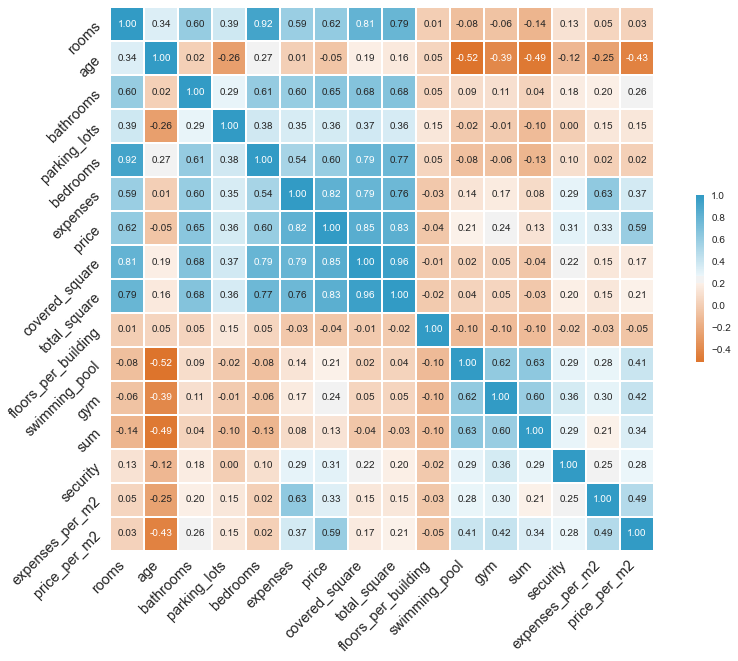

In [41]:
corr = df.corr()

# figure
fig, ax = plt.subplots(figsize=(15,10))

# color map
cmap = sns.diverging_palette(30, 230, 90, 60, as_cmap=True)

# plt heatmap
g = sns.heatmap(corr, 
                cmap=cmap, 
                annot=True, 
                fmt=".2f", 
                linewidths=1,
                square=True, 
                cbar_kws={'fraction' : 0.01},
                )

g.set_xticklabels(g.get_xticklabels(),
                  rotation=45, 
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-large'
                 )
g.set_yticklabels(g.get_yticklabels(), 
                  rotation=45, 
                  horizontalalignment='right',
                  fontweight='light',
                  fontsize='x-large')

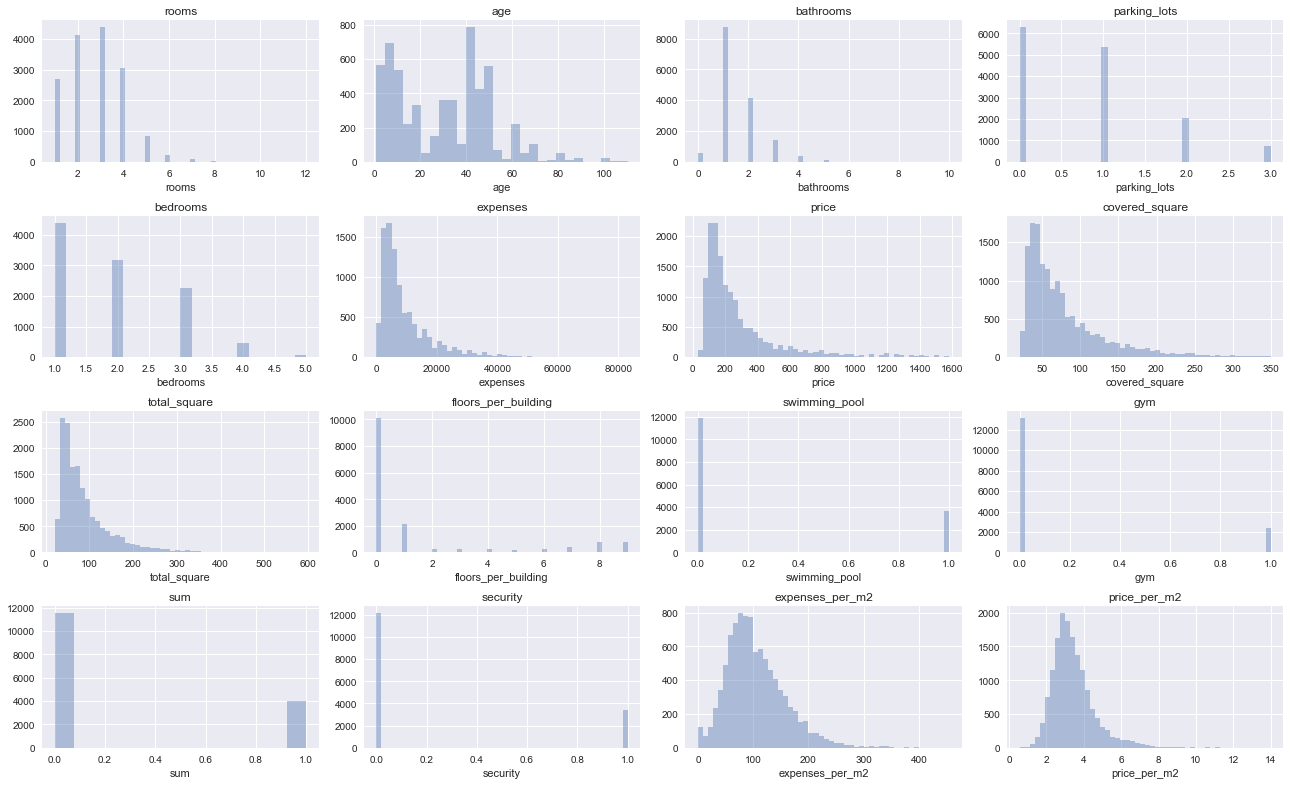

In [42]:
# Plot distributions

fig = plt.figure(figsize=(18,16))
for index,col in enumerate(df.drop('district', axis=1).dropna()):
    plt.subplot(6,4,index+1)
    sns.distplot(data.loc[:,col].dropna(), kde=False).set_title(str(col))
fig.tight_layout(pad=1.0)

In [43]:
rooms = df.rooms.value_counts().to_frame()

fig = px.pie(
    rooms, 
    values='rooms', 
    names=rooms.index,
    title='How many rooms in the apartments?',
    color='rooms',
    hole=0.3
)
fig.update_traces(
    textposition='inside',
    textfont_size=20,
    marker=dict(line=dict(color='#000000', width=2))
)

fig.update_layout(
    legend_title='Number of rooms'
)
fig.show()

In [44]:
fig = px.box(data, x='district', y='price_per_m2', color='district')
fig.show()

In [45]:
# Dash plotly interactive plot. It can't be visible in nbviewer.
"""
dash_df = data

app = JupyterDash(__name__)

app.layout = html.Div([
    
    html.Div([
        html.Label(['Values to compare'], style={'font-weight':'bold'}),
        dcc.RadioItems(
            id='my_radioitem',
            options=[
                {'label':'Building Age', 'value': 'age'},
                {'label':'Expenses (in AR$)', 'value': 'expenses'},
                {'label':'Apartment Price (in 1000$)', 'value': 'price'},
                {'label':'Apartment Covered Square (in m^2)', 'value':'covered_square'},
                {'label':'Expenses per m^2', 'value': 'expenses_per_m2'},
                {'label':'Price per m^2 (in 1000$)', 'value':'price_per_m2'},
            ],
            value='age',
            style={'width':'100%','font-size':'80%'}
        ),
    ]),
    
    html.Div([
        dcc.Graph(id='my_graph')
    ])
])

@app.callback(
    Output(component_id='my_graph', component_property='figure'),
    [Input(component_id='my_radioitem', component_property='value')]
)

def update_graph(y_axis):
    
    dff = dash_df
    
    boxplot = px.box(
        data_frame = dff,
        x = 'district',
        y = y_axis,
        title = y_axis+' by District',
        color='district',
    )
    
    boxplot.update_layout(xaxis={'categoryorder':'mean descending'},
                         title={'xanchor':'center','yanchor':'top','y':0.9, 'x':0.5})
    
    return(boxplot)

if __name__=='__main__':
    app.run_server(debug=True, mode='inline')
"""

"\ndash_df = data\n\napp = JupyterDash(__name__)\n\napp.layout = html.Div([\n    \n    html.Div([\n        html.Label(['Values to compare'], style={'font-weight':'bold'}),\n        dcc.RadioItems(\n            id='my_radioitem',\n            options=[\n                {'label':'Building Age', 'value': 'age'},\n                {'label':'Expenses (in AR$)', 'value': 'expenses'},\n                {'label':'Apartment Price (in 1000$)', 'value': 'price'},\n                {'label':'Apartment Covered Square (in m^2)', 'value':'covered_square'},\n                {'label':'Expenses per m^2', 'value': 'expenses_per_m2'},\n                {'label':'Price per m^2 (in 1000$)', 'value':'price_per_m2'},\n            ],\n            value='age',\n            style={'width':'100%','font-size':'80%'}\n        ),\n    ]),\n    \n    html.Div([\n        dcc.Graph(id='my_graph')\n    ])\n])\n\n@app.callback(\n    Output(component_id='my_graph', component_property='figure'),\n    [Input(component_id='my_ra

<a id="bootstrap"></a>

## Bootstrap Hypothesis Testing

I want to find answers for the next two questions:

- Which district is more expensive: Palermo o Recoleta?

- Is it true that any person who has an apartment in a exclusive district like Palermo or Recoleta pays more expenses on average than any person who has an apartment in some middle-class district like Flores or Caballito?

I'm going to use a such statistical tool as **Bootstrap Hypothesis Testing**.

In [46]:
def bootstrap_test_statistic(dist1, dist2, func):
    
    """Function designed for generating bootstrap statistic of difference between 2 distributions
    
    Parameters:
    ===========
    dist1 , dist 2 : arrays 
    func : function of statistic to extimate (np.mean, np.median etc..)
    
    Returns:
    ========
    A difference between 2 arrays.
    """
    bs_sample_data1 = np.random.choice(dist1, len(dist1))
    bs_sample_data2 = np.random.choice(dist2, len(dist2))
    
    bs_test_stat = func(bs_sample_data1) - func(bs_sample_data2)
    
    return np.round(bs_test_stat, 3)

<a id="palermo-vs-recoleta"></a>

### Palermo vs Recoleta. Which district is more expensive?

In [47]:
# Subset only Palermo and Recoleta data and save it as "pal_vs_rec"
pal_vs_rec = df[df.district.isin(['Palermo','Recoleta'])]
pal_vs_rec = pal_vs_rec.loc[:, ['district','price_per_m2']]

# inspect means
print(pal_vs_rec.groupby('district').mean().sort_values(by='price_per_m2')[:2])

          price_per_m2
district              
Recoleta      3.523351
Palermo       3.986325


In [48]:
px.box(pal_vs_rec, x='district', y='price_per_m2')

It seems that Palermo is more expensive than Recoleta, but I want to be sure and for that reason I use [Hypothesis Testing](https://en.wikipedia.org/wiki/Statistical_hypothesis_testing).

My null hypothesis is that the price means of this districts are the same.

$H_0: mean_{palermo} - mean_{recoleta} <= 0$

$H_a: mean_{palermo} - mean_{recoleta} > 0$

In [49]:
# get palermo and recoleta price per m^2 distributions
palermo_prices = np.array(pal_vs_rec[pal_vs_rec.district == 'Palermo']['price_per_m2'])
recoleta_prices = np.array(pal_vs_rec[pal_vs_rec.district == 'Recoleta']['price_per_m2'])

# the mean of an array of two distribution
both_districts_mean = np.round(np.mean(pal_vs_rec['price_per_m2']),4)
print('Both districts mean: ', both_districts_mean)

# palermo prices mean
palermo_mean = np.round(np.mean(palermo_prices),4)
print('Palermo mean: ', palermo_mean)

# recoleta prices mean
recoleta_mean = np.round(np.mean(recoleta_prices),4)
print('Recoleta mean: ', recoleta_mean)

# observed test statistic
observed_test_statistic = np.round(palermo_mean - recoleta_mean,4)
print('The difference of means: ', observed_test_statistic)

Both districts mean:  3.7879
Palermo mean:  3.9863
Recoleta mean:  3.5234
The difference of means:  0.4629


In [50]:
# shift both distributions to have difference of their means centered right on 0
palermo_prices_shifted = palermo_prices - palermo_mean + both_districts_mean
recoleta_prices_shifted = recoleta_prices - recoleta_mean + both_districts_mean

# number of samples to simulate
bootstrap_samples_number = 10000 

# create empty array
bs_test_replicates = np.empty(bootstrap_samples_number)

# generate bootstrap samples, calculate test statistic and save it in the array
for i in range(bootstrap_samples_number):
    bs_test_replicates[i] = bootstrap_test_statistic(palermo_prices_shifted, recoleta_prices_shifted, np.mean)

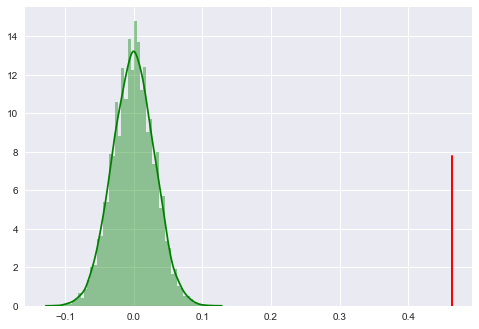

In [51]:
# plot the distribution of bootstrap test statistics and observed test statistic
sns.distplot(bs_test_replicates, color='green')
plt.axvline(observed_test_statistic, color='red', linewidth=2, ymax=0.5)

In [52]:
np.sum(bs_test_replicates >= observed_test_statistic)

0

In [53]:
# calculate p-value
p = np.sum(bs_test_replicates >= observed_test_statistic) / len(bs_test_replicates)

if p <= 0.05:
    print('p-value is ', p)
    print('Null hypothesis is rejected')
else:
    print('p-value is ', p)
    print('No evidence for rejecting null hypothesis')

p-value is  0.0
Null hypothesis is rejected


Assuming that this two distribution have the same mean, I simulated 10000 distributions for both districts (sampling with replacement) and calculated 10000 differences of means. The result is that we get 0 values that are equal or more than our <code>observed_test_statistic</code> and calculated [p-value](https://en.wikipedia.org/wiki/P-value). There is a very significant evidence that Palermo is more expensive than Recoleta.

<a id="palermo-vs-caballito"></a>

### Do habitants of Palermo district pay more expenses than habitants of Caballito?

In [54]:
# subset only Palermo and Caballito data and save it as "pal_vs_cab"
df = data.dropna(subset=['expenses_per_m2']).copy()

pal_vs_cab = df[df.district.isin(['Palermo', 'Caballito'])]

pal_vs_cab = pal_vs_cab.loc[:, ['district', 'expenses_per_m2']]

print(pal_vs_cab.groupby('district').mean().sort_values(by='expenses_per_m2')[:2])

           expenses_per_m2
district                  
Caballito        85.693810
Palermo         126.353668


In [55]:
px.box(pal_vs_cab, x='district', y = 'expenses_per_m2')

It seems that people in Palermo district pay more expenses.

My null hypothesis is that the price means of this districts are the same.

$H_0: mean_{palermo} - mean_{caballito} <= 0$

$H_a: mean_{palermo} - mean_{caballito} > 0$

In [56]:
# get palermo and caballito expenses per m^2 distributions.
palermo_expenses = np.array(pal_vs_cab[pal_vs_cab.district == 'Palermo']['expenses_per_m2'])
caballito_expenses = np.array(pal_vs_cab[pal_vs_cab.district == 'Caballito']['expenses_per_m2'])

# common mean between 2 districts distributions
both_districts_mean = np.round(np.mean(pal_vs_cab['expenses_per_m2']),4)
print("Both districts mean: ", both_districts_mean)

# palermo expenses mean
palermo_mean = np.round(np.mean(palermo_expenses),4)
print("Palermo mean: ", palermo_mean)

# caballito expenses mean
caballito_mean = np.round(np.mean(caballito_expenses),4)
print("Caballito mean: ", caballito_mean)

# observed test statistic
observed_test_statistic = np.round(palermo_mean - caballito_mean,4)
print('The difference of means: ', observed_test_statistic)

Both districts mean:  115.096
Palermo mean:  126.3537
Caballito mean:  85.6938
The difference of means:  40.6599


In [57]:
# shifting distributions to have difference of means rigth on 0
palermo_expenses_shifted = palermo_expenses - palermo_mean + both_districts_mean
caballito_expenses_shifted = caballito_expenses - caballito_mean + both_districts_mean

# number of samples to simulate
bootstrap_samples_number = 10000 

# empty array
bs_test_replicates = np.empty(bootstrap_samples_number)

# get out bootstap test statistics
for i in range(bootstrap_samples_number):
    bs_test_replicates[i] = bootstrap_test_statistic(palermo_expenses_shifted, caballito_expenses_shifted, np.mean)

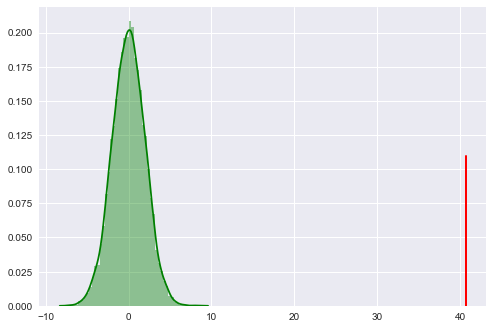

In [58]:
# plot the distribution of bootstrap statistics and point the observed test statistic 
sns.distplot(bs_test_replicates, color='green')
plt.axvline(observed_test_statistic, color='red', linewidth=2, ymax=0.5)

In [59]:
np.sum(bs_test_replicates >= observed_test_statistic)

0

In [60]:
# calculate p-value
p = np.sum(bs_test_replicates >= observed_test_statistic) / len(bs_test_replicates)

if p <= 0.05:
    print('p-value is ', p)
    print('Null hypothesis is rejected')
else:
    print('p-value is ', p)
    print('No evidence for rejecting null hypothesis')

p-value is  0.0
Null hypothesis is rejected


Assuming that this two distribution have the same mean, I simulated 10000 distributions for both districts (sampling with replacement) and calculated 10000 differences of means. The result is that we get 0 values that are equal or more that over <code>observed_test_statistic</code> and calculated [p-value](https://en.wikipedia.org/wiki/P-value). There is a very significant evidence that Palermo is more expensive than Caballito.

<a id="geo-data"></a>

## Geograpthic Data

I was able to find a geoJSON file with Buenos Aires districts localization values. This file you can get [here](https://data.buenosaires.gob.ar/dataset/barrios/archivo/1c3d185b-fdc9-474b-b41b-9bd960a3806e)

In [61]:
prices = df.groupby('district')['price_per_m2'].mean().to_frame()
barrios = gpd.read_file('barrios.geojson')

prices = prices.reset_index()
prices.columns = ['name', 'price']

I need to set all district names to be equal in both datasets. The next function is designed to replace some letters in the districts name.

In [62]:
def replacer(word):
    
    word = word.replace('í', 'i')
    word = word.replace('ó', 'o')
    word = word.replace('ú', 'u')
    word = word.replace('é', 'e')
    
    return word

In [63]:
# apply the fucntion on both datasets
prices.name = prices.name.apply(lambda x: replacer(x))
barrios.name = barrios.name.apply(lambda x: replacer(x))

<a id="geo-price"></a>

### Average price_per_meter by district

In [64]:
m = folium.Map([-34.6083, -58.3712], zoom_start=12)

folium.Choropleth(
    geo_data=barrios,
    data=prices,
    columns=['name', 'price'],
    key_on='feature.properties.name',
    fill_color='YlOrRd',
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color='purple',
    nan_fill_opacity=0.4,
    legend_name='Average price per squared meter (1000$)',
    highlight=True,
).add_to(m)

folium.map.CustomPane("labels").add_to(m)

folium.TileLayer("CartoDBPositronOnlyLabels", pane="labels").add_to(m)

In [65]:
display(m)

In this map purple is missing data. One of the reasons for that: 

- these districts has to few apartments for sell (according the dataset)

<a id="geo-square"></a>

### Average covered_square by district

In [66]:
square = df.groupby('district')['covered_square'].mean().to_frame()

square = square.reset_index()
square.columns = ['name', 'avg_square']

In [67]:
m = folium.Map([-34.6083, -58.3712], zoom_start=12)

folium.Choropleth(
    geo_data=barrios,
    data=square,
    columns=['name', 'avg_square'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color='purple',
    nan_fill_opacity=0.4,
    legend_name='Average covered square in squared meters',
    highlight=True,
).add_to(m)

folium.map.CustomPane("labels").add_to(m)

folium.TileLayer("CartoDBPositronOnlyLabels", pane="labels").add_to(m)

In [68]:
display(m)

<a id="geo-age"></a>

### Average age by district

In [69]:
age = df.groupby('district')['age'].mean().to_frame()

age = age.reset_index()

age.columns = ['name', 'avg_age']

In [70]:
m = folium.Map([-34.6083, -58.3712], zoom_start=12)

folium.Choropleth(
    geo_data=barrios,
    data=age,
    columns=['name', 'avg_age'],
    key_on='feature.properties.name',
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.3,
    nan_fill_color='purple',
    nan_fill_opacity=0.4,
    legend_name='Average age in years',
    highlight=True,
).add_to(m)

folium.map.CustomPane("labels").add_to(m)

folium.TileLayer("CartoDBPositronOnlyLabels", pane="labels").add_to(m)

In [71]:
display(m)

<a id="linear-model"></a>

## Linear Model

I interested in <code>price</code> inference and I would use [forward-stepwise-selection](https://en.wikipedia.org/wiki/Stepwise_regression) regression based on "Adj. R-squared" criterion.

In [72]:
import statsmodels.formula.api as smf

def forward_selected(data, response):
    """Linear model designed by forward selection.

    Parameters:
    -----------
    data : pandas DataFrame with all possible predictors and response

    response: string, name of response column in data

    Returns:
    --------
    model: an "optimal" fitted statsmodels linear model
           with an intercept
           selected by forward selection
           evaluated by adjusted R-squared
    """
    remaining = set(data.columns)
    remaining.remove(response)
    selected = []
    current_score, best_new_score = 0.0, 0.0
    while remaining and current_score == best_new_score:
        scores_with_candidates = []
        for candidate in remaining:
            formula = "{} ~ {} + 1".format(response,
                                           ' + '.join(selected + [candidate]))
            score = smf.ols(formula, data).fit().rsquared_adj
            scores_with_candidates.append((score, candidate))
        scores_with_candidates.sort()
        best_new_score, best_candidate = scores_with_candidates.pop()
        if current_score < best_new_score:
            remaining.remove(best_candidate)
            selected.append(best_candidate)
            current_score = best_new_score
    formula = "{} ~ {} + 1".format(response,
                                   ' + '.join(selected))
    model = smf.ols(formula, data).fit()
    return model

In [73]:
df = data.dropna().copy()

df['log_price'] = df.price.apply(lambda x: np.log(x))
df = df.drop(['price_per_m2','price'], axis=1)
df = df.reset_index(drop=True)
df = pd.get_dummies(df)
df.shape

columns = df.columns.to_list()
new_columns = []
for col in columns:
    col = col.replace(' ', '_')
    new_columns.append(col)

df.columns = new_columns

model = forward_selected(df, 'log_price')

In [74]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              log_price   R-squared:                       0.884
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     708.9
Date:                Tue, 15 Sep 2020   Prob (F-statistic):               0.00
Time:                        16:29:57   Log-Likelihood:                 246.80
No. Observations:                4425   AIC:                            -397.6
Df Residuals:                    4377   BIC:                            -90.64
Df Model:                          47                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept             

### And that's it. Thank you very much for your time!